In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
%%
# Importing Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score

import os
os.listdir('../input')

['mydataTest.csv', 'mydataTrain.csv']

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
trainfurnace = pd.read_csv('../input/dataTrain.csv')
testfurnace = pd.read_csv('../input/dataTest.csv')

In [4]:
trainfurnace.shape, testfurnace.shape

((999, 12), (297, 12))

## Concatenating train and test data

In [5]:
trainfurnace['data'] = 'Train'
testfurnace['data'] = 'Test'

In [6]:
# Renaming Fe+AF8-Content to Fe_Content in test data
testfurnace['Fe_Content'] = testfurnace['Fe+AF8-Content']
del testfurnace['Fe+AF8-Content']

In [7]:
data = pd.concat([trainfurnace, testfurnace], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
data.shape

(1296, 13)

In [9]:
data.columns

Index(['AirHumidity', 'Al2O3', 'BlastAirTemp', 'Burden', 'CO2Exhaust',
       'Fe_Content', 'OreSource', 'Oxygen', 'Productivity', 'S.No',
       'SinterQuality', 'TopAirPressure', 'data'],
      dtype='object')

In [10]:
# deleting S.No as it won't have any affect on prediction
del data['S.No']

## Data Visualization

PairPlots

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


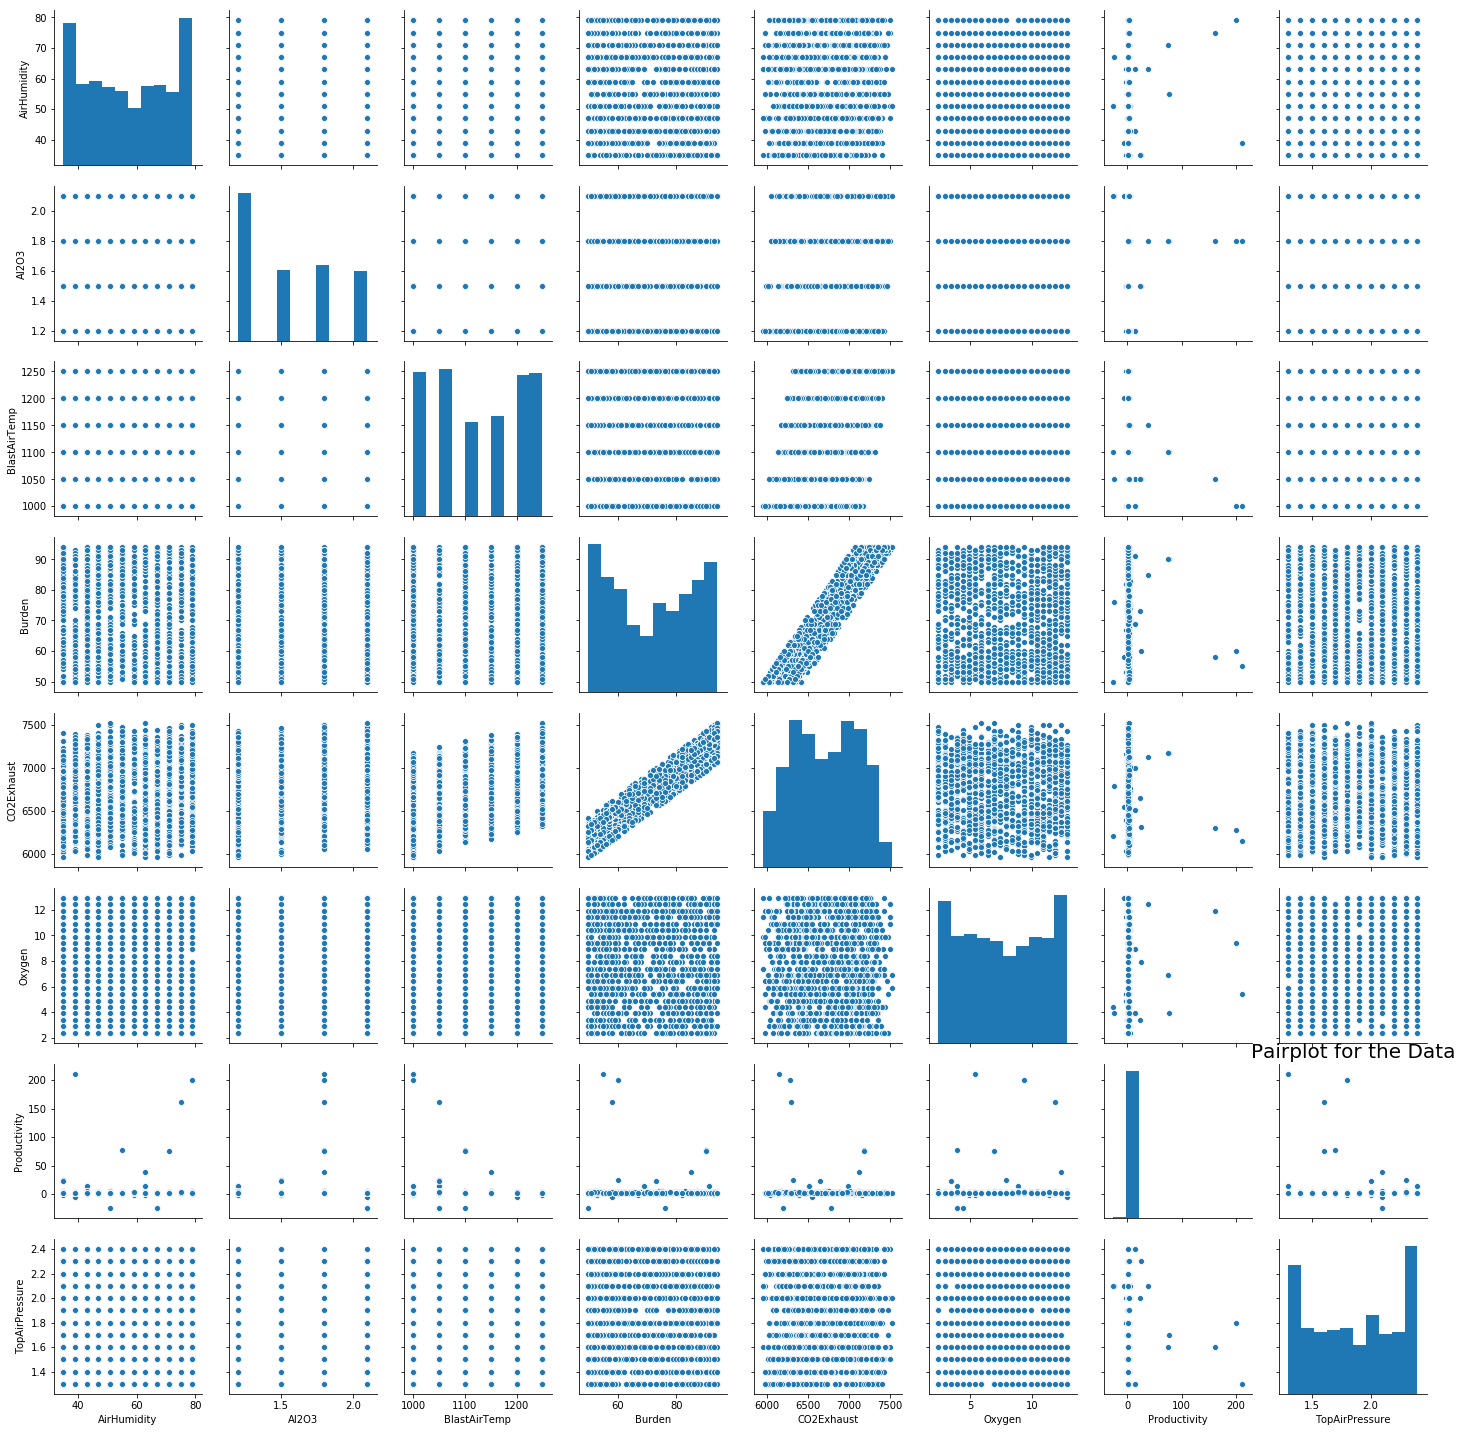

In [11]:
sns.pairplot(data)
plt.title('Pairplot for the Data', fontsize = 20)
plt.show()

## Inference
It is seen that CO2Exhaust and Burden are linearly dependent on each other i.e. correlated

By looking at productivity pairplots , we see that it has some negative values which doesnt makes sense
And also it has many outliers.

We can either remove these data or make them positive

In [12]:
data[data['Productivity']<0]

,AirHumidity,Al2O3,BlastAirTemp,Burden,CO2Exhaust,Fe_Content,OreSource,Oxygen,Productivity,SinterQuality,TopAirPressure,data
139,47,2.1,1050,51,6154.2,Medium,NaN,2.4,-0.079077,High,1.4,Train
221,59,1.5,1250,82,7158.6,Low,D,5.4,-2.282857,Low,2.0,Train
285,43,2.1,1000,73,6636.6,Medium,NaN,10.4,-0.052615,Low,1.7,Train
315,67,2.1,1050,76,6784.2,Medium,V,3.9,-24.652000,Low,2.1,Train
486,51,2.1,1100,50,6201.0,Low,NaN,4.4,-24.812000,High,2.1,Train
584,63,1.2,1000,53,6035.4,High,NaN,4.9,-1.873617,Low,1.8,Train
622,35,1.2,1000,67,6388.2,Low,V,11.4,-1.269362,High,1.8,Train
824,39,2.1,1200,58,6546.6,High,NaN,12.9,-5.052000,Low,2.1,Train
908,43,1.5,1000,93,7075.8,Medium,V,12.4,-0.031321,Medium,1.9,Train


There are 9 negative values of productivity in the data we will make them as positive.

In [13]:
data['Productivity'] = np.where(data['Productivity']<0, abs(data['Productivity']), data['Productivity'])

In [14]:
data[data['Productivity']<0]

,AirHumidity,Al2O3,BlastAirTemp,Burden,CO2Exhaust,Fe_Content,OreSource,Oxygen,Productivity,SinterQuality,TopAirPressure,data


## Check for Null values

In [15]:
data.isnull().sum()

AirHumidity         0
Al2O3               0
BlastAirTemp        0
Burden              0
CO2Exhaust          0
Fe_Content          0
OreSource         864
Oxygen              0
Productivity      297
SinterQuality       0
TopAirPressure      0
data                0
dtype: int64

## Here we see around 65% of the OreSource values are Null

Productivity null values belong to Test data

## OreSource

In [16]:
Oredata = data[data['OreSource'].isnull() == False]

In [17]:
Oredata.shape

(432, 12)

In [18]:
Oredata['OreSource'].value_counts()

V    103
A     63
F     56
B     42
S     41
D     38
H     29
C     14
E     13
G     11
Y     11
K     11
Name: OreSource, dtype: int64

Here we will consider data without outliers that is less than 5

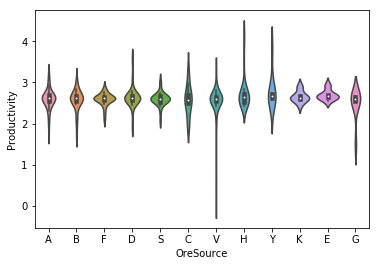

In [19]:
sns.violinplot(x='OreSource', y='Productivity', data=Oredata[Oredata['Productivity']<5])

## OreSource C, H, Y, G has productivity range higher

In [20]:
trainfurnace['OreSource'].value_counts()

V    82
A    53
F    41
B    32
D    32
S    30
H    20
C    11
K    10
E    10
Y    10
G     9
Name: OreSource, dtype: int64

In [21]:
testfurnace['OreSource'].value_counts()

V    21
F    15
S    11
B    10
A    10
H     9
D     6
C     3
E     3
G     2
Y     1
K     1
Name: OreSource, dtype: int64

## Since OreSource C, H, Y, G are less frequent in both train and test data , it shouldn't have much impact on prediction

In [22]:
del data['OreSource']

## CO2Exhaust

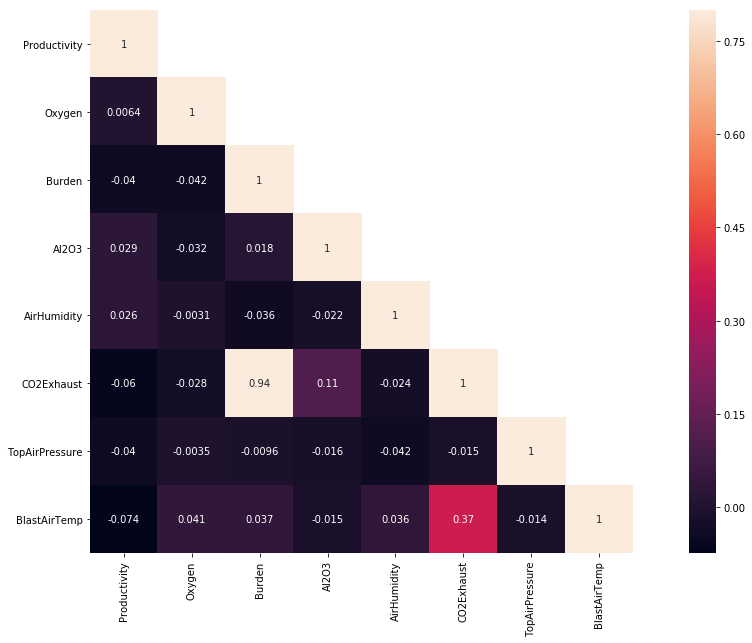

In [23]:
corrMatt = data[["Productivity","Oxygen","Burden","Al2O3","AirHumidity","CO2Exhaust","TopAirPressure", "BlastAirTemp"]].corr()
mask = np.array(corrMatt)
np.tril_indices_from(mask)
mask[np.tril_indices_from(mask)]

mask[np.tril_indices_from(mask)] = False # only checking lower triangle correlations as it will be same on lowerside
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

## CO2Exhaust and Burden has a very high Correlation, Of the two the one which has low correlation with Productivity(target) will be dropped i.e CO2Exhaust

In [24]:
del data['CO2Exhaust']

## Pointplots

In [25]:
train = data[data['data'] == 'Train'] 

In [26]:
#Considering productivity more than 4 as outliers
trainWithoutOutliers = train[train['Productivity']<=4]

In [27]:
trainWithoutOutliers.shape

(973, 10)

[Text(0, 0.5, 'Productivity'),
 Text(0.5, 0, 'TopAirPressure'),
 Text(0.5, 1.0, 'Average Productivity Across Fe_Content'),
 None]

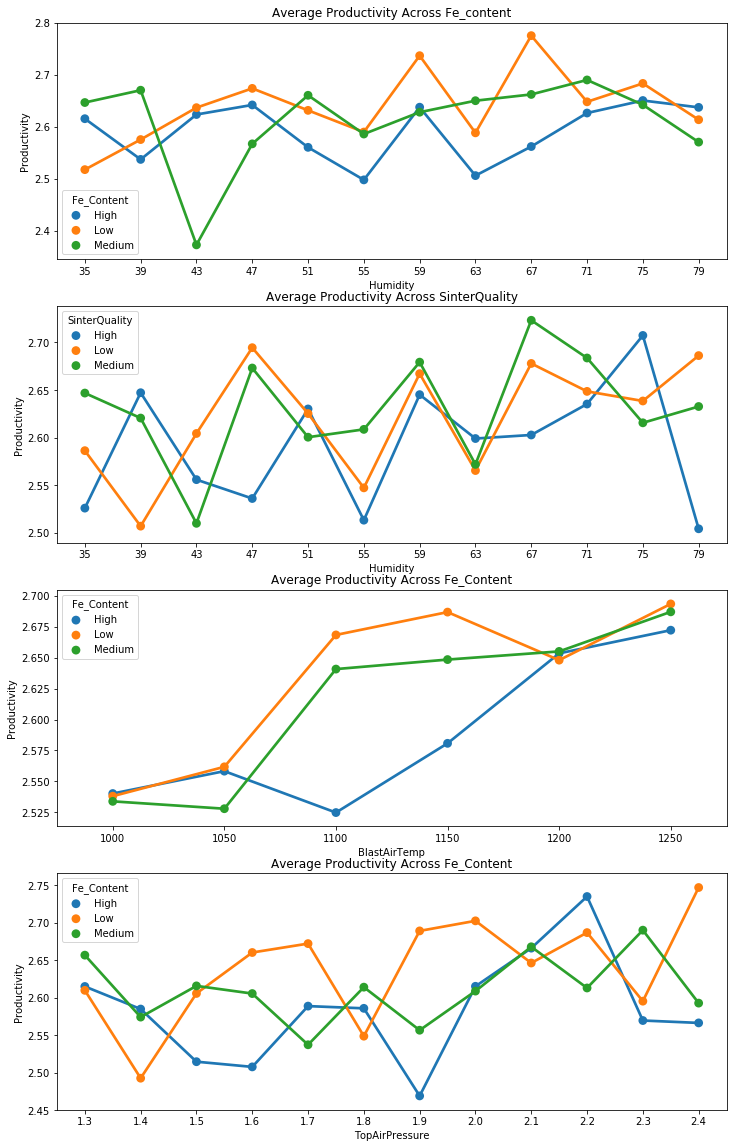

In [29]:
fig,(ax1,ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
#furnacedataWithoutOutliers
HumidityAggregated = pd.DataFrame(trainWithoutOutliers.groupby(["AirHumidity","Fe_Content"],sort=True)["Productivity"].mean()).reset_index()
sns.pointplot(x=HumidityAggregated["AirHumidity"], y=HumidityAggregated["Productivity"],hue=HumidityAggregated["Fe_Content"], data=HumidityAggregated, join=True,ax=ax1)
ax1.set(xlabel='Humidity', ylabel='Productivity',title="Average Productivity Across Fe_content",label='big')

HumidityAggregated = pd.DataFrame(trainWithoutOutliers.groupby(["AirHumidity","SinterQuality"],sort=True)["Productivity"].mean()).reset_index()
sns.pointplot(x=HumidityAggregated["AirHumidity"], y=HumidityAggregated["Productivity"],hue=HumidityAggregated["SinterQuality"], data=HumidityAggregated, join=True,ax=ax2)
ax2.set(xlabel='Humidity', ylabel='Productivity',title="Average Productivity Across SinterQuality",label='big')

BlastAirAggregated = pd.DataFrame(trainWithoutOutliers.groupby(["BlastAirTemp","Fe_Content"],sort=True)["Productivity"].mean()).reset_index()
sns.pointplot(x=BlastAirAggregated["BlastAirTemp"], y=BlastAirAggregated["Productivity"],hue=BlastAirAggregated["Fe_Content"], data=BlastAirAggregated, join=True,ax=ax3)
ax3.set(xlabel='BlastAirTemp', ylabel='Productivity',title="Average Productivity Across Fe_Content",label='big')

TopPressAggregated = pd.DataFrame(trainWithoutOutliers.groupby(["TopAirPressure","Fe_Content"],sort=True)["Productivity"].mean()).reset_index()
sns.pointplot(x=TopPressAggregated["TopAirPressure"], y=TopPressAggregated["Productivity"],hue=TopPressAggregated["Fe_Content"], data=TopPressAggregated, join=True,ax=ax4)
ax4.set(xlabel='TopAirPressure', ylabel='Productivity',title="Average Productivity Across Fe_Content",label='big')

Its interesting to see that productivity is almost same at temp 1100 and 1200 for different Fe_content 
TopAirPressure doesnt show any pattern

## Create dummies

In [30]:
dummy1=pd.get_dummies(data['Fe_Content'],drop_first=True,prefix='Fe')
data=pd.concat([data,dummy1],axis=1)
dummy=pd.get_dummies(data['SinterQuality'],drop_first=True,prefix='Sinter')
data=pd.concat([data,dummy],axis=1)

In [31]:
data = data.drop(['Fe_Content', 'SinterQuality'], axis=1)

## Separating train and test

In [32]:
traindata = data[data['data'] == 'Train'] 
test = data[data['data'] == 'Test'] 
del traindata['data']
del test['data']

In [33]:
del test['Productivity']
#del test['Al2O3']

## Outliers

### Productivity values greater than 5 and less than 1.5 are considered as outliers

In [34]:
traindata[traindata['Productivity']<1.5].shape

(10, 11)

In [35]:
dataWithoutOutliers1 = traindata[traindata['Productivity']<=5]
dataWithoutOutliers = dataWithoutOutliers1[dataWithoutOutliers1['Productivity']>1.5]

In [36]:
x = dataWithoutOutliers.drop(['Productivity'], 1)
y = dataWithoutOutliers['Productivity']

In [37]:
print ("Shape Of The data Before Ouliers: ",traindata.shape)
print ("Shape Of The data After Ouliers: ",dataWithoutOutliers.shape)

Shape Of The data Before Ouliers:  (999, 11)
Shape Of The data After Ouliers:  (971, 11)


In [38]:
x.head(2)

,AirHumidity,Al2O3,BlastAirTemp,Burden,Oxygen,TopAirPressure,Fe_Low,Fe_Medium,Sinter_Low,Sinter_Medium
0,67,2.1,1000,52,8.9,2.2,0,1,0,1
1,47,1.8,1250,68,12.9,1.4,1,0,1,0


In [39]:
test.head(2)

,AirHumidity,Al2O3,BlastAirTemp,Burden,Oxygen,TopAirPressure,Fe_Low,Fe_Medium,Sinter_Low,Sinter_Medium
0,67,1.2,1250,56,10.4,1.8,1,0,0,0
1,67,1.2,1200,88,10.9,1.4,0,1,0,0


In [40]:
x.shape, test.shape

((971, 10), (297, 10))

## Convert productivity to log

In [41]:
y_label = np.log1p(y)

In [42]:
y_label[y_label.isnull()]

Series([], Name: Productivity, dtype: float64)

In [43]:
y_label[y_label<0]

Series([], Name: Productivity, dtype: float64)

In [44]:
pd.concat([y, y_label], axis=1).head()

,Productivity,Productivity
0,2.272991,1.185704
1,2.670328,1.300281
2,2.669834,1.300146
3,2.401378,1.224181
4,2.679802,1.302859


## Permutation IMportance

In [45]:
from sklearn.model_selection import train_test_split
tx, val_x, ty, val_y = train_test_split(x, y, test_size=0.1, random_state=1)

In [46]:
import eli5
from eli5.sklearn import PermutationImportance

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [47]:
my_model = RandomForestRegressor(random_state=1).fit(tx, ty)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [48]:
perm = PermutationImportance(my_model, random_state=1).fit(val_x, val_y)
eli5.show_weights(perm, feature_names = val_x.columns.tolist())

Weight,Feature
0.2754 ± 0.3134,Oxygen
0.1811 ± 0.2167,BlastAirTemp
0.1582 ± 0.3758,AirHumidity
0.0797 ± 0.0815,Fe_Low
0.0564 ± 0.2888,TopAirPressure
0.0534 ± 0.2454,Sinter_Medium
0.0357 ± 0.1889,Sinter_Low
0.0265 ± 0.1159,Al2O3
0.0123 ± 0.0272,Fe_Medium
0.0052 ± 0.1166,Burden


### Most important feature is shown as Oxygen but that depends on outliers , if we consider above 3 as outliers we may get different feature

## Partial Dependance Plots

In [49]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots


feature_names = [i for i in x.columns if x[i].dtype in [np.int64, np.float64]]
# Create the data that we will plot

X = x[feature_names]
x_train, x_val, y_train, y_val = train_test_split(X, y, random_state=1)

In [50]:
feature_names

['AirHumidity', 'Al2O3', 'BlastAirTemp', 'Burden', 'Oxygen', 'TopAirPressure']

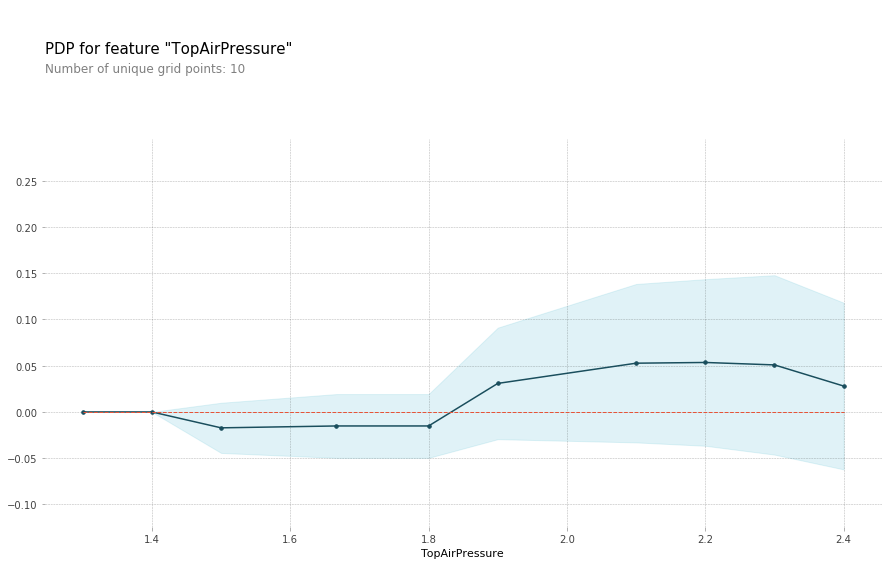

In [51]:
tree_model = RandomForestRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(x_train, y_train)
pdp_TopAirPressure = pdp.pdp_isolate(model=tree_model, dataset=x_val, model_features=feature_names, feature='TopAirPressure')

# plot it
pdp.pdp_plot(pdp_TopAirPressure, 'TopAirPressure')
plt.show()

TopAirPressure above 1.8 increases productivity to a certain value

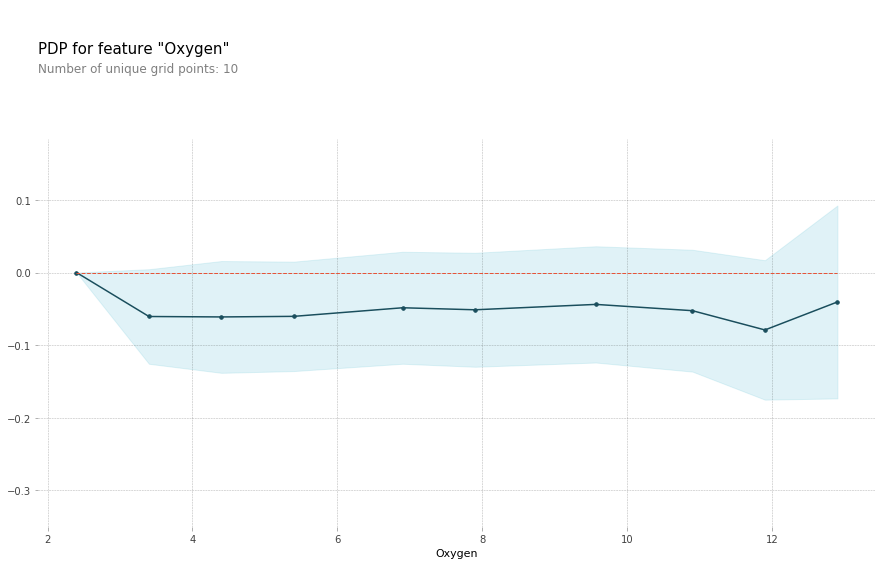

In [52]:
tree_model = RandomForestRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(x_train, y_train)
pdp_Oxygen = pdp.pdp_isolate(model=tree_model, dataset=x_val, model_features=feature_names, feature='Oxygen')

# plot it
pdp.pdp_plot(pdp_Oxygen, 'Oxygen')
plt.show()

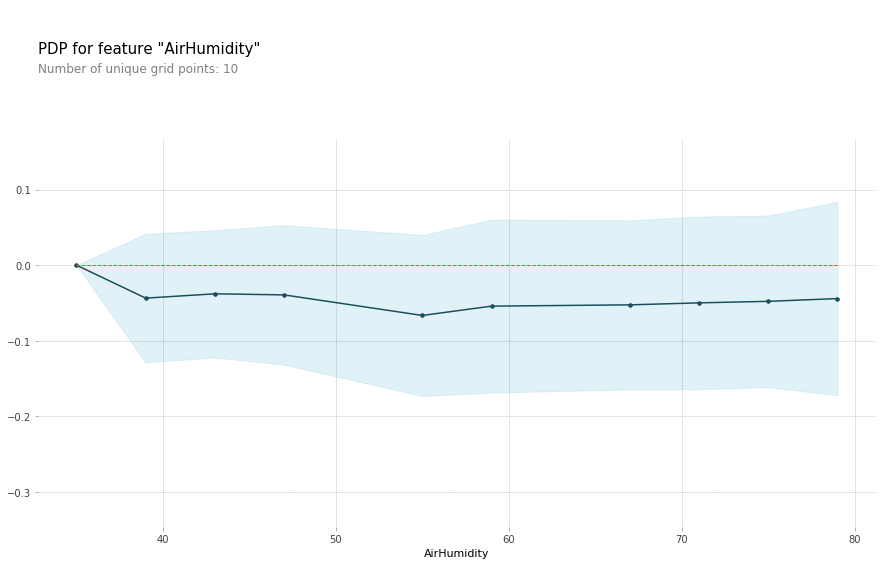

In [53]:
tree_model = RandomForestRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(x_train, y_train)
pdp_Humidity = pdp.pdp_isolate(model=tree_model, dataset=x_val, model_features=feature_names, feature='AirHumidity')

# plot it
pdp.pdp_plot(pdp_Humidity, 'AirHumidity')
plt.show()

### Humidity generally decreases productivity

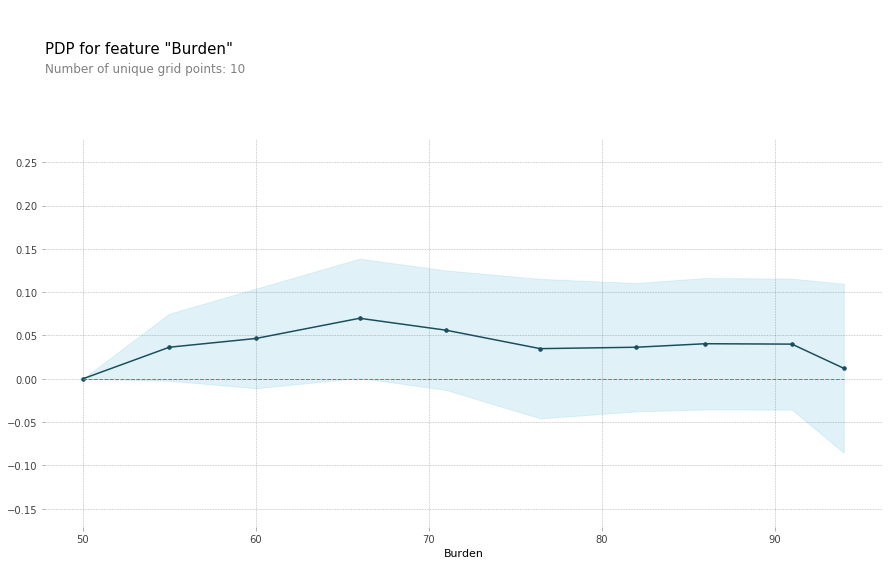

In [54]:
tree_model = RandomForestRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(x_train, y_train)
pdp_Burden = pdp.pdp_isolate(model=tree_model, dataset=x_val, model_features=feature_names, feature='Burden')

# plot it
pdp.pdp_plot(pdp_Burden, 'Burden')
plt.show()

### Burden between 60 and 70 gives more productivity

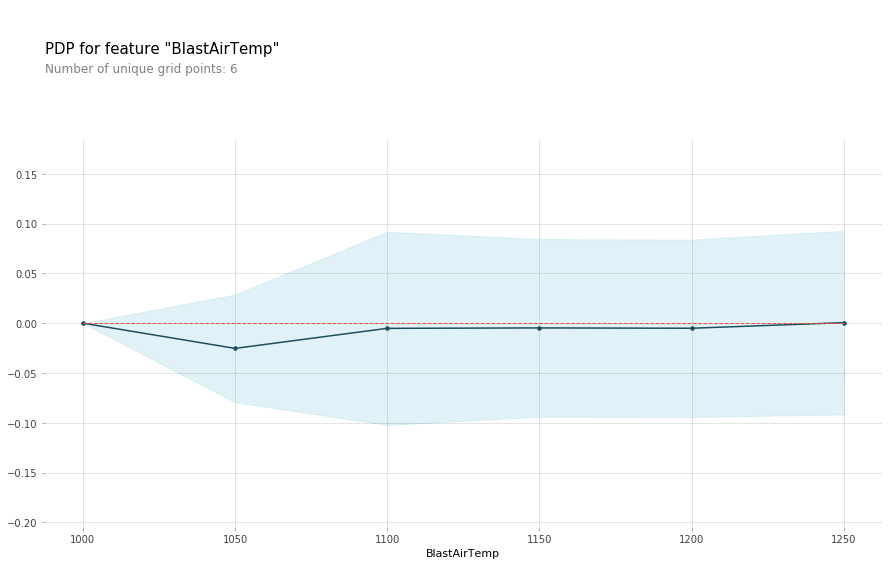

In [55]:
tree_model = RandomForestRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(x_train, y_train)
pdp_BlastTemp = pdp.pdp_isolate(model=tree_model, dataset=x_val, model_features=feature_names, feature='BlastAirTemp')

# plot it
pdp.pdp_plot(pdp_BlastTemp, 'BlastAirTemp')
plt.show()

## optimum BlastAirTemp is seen to be 1200 to 1250

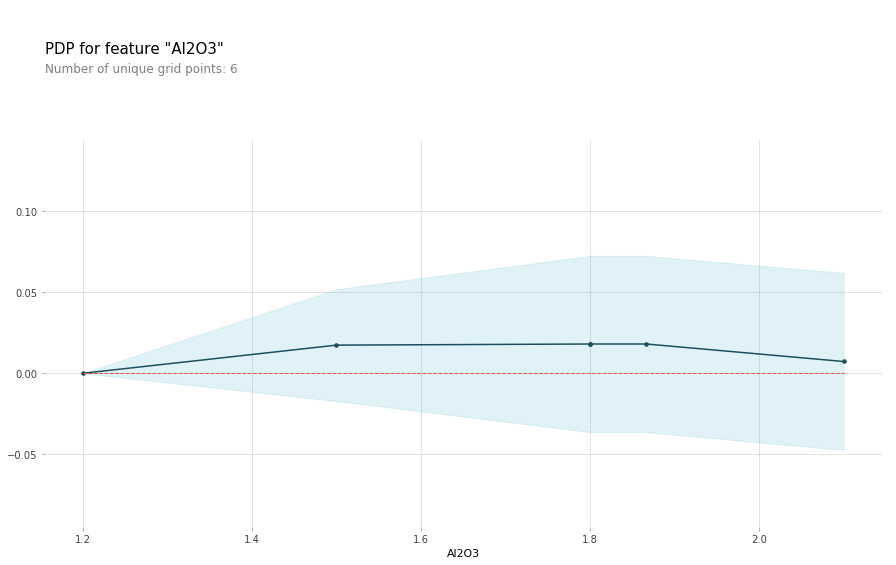

In [56]:
tree_model = RandomForestRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(x_train, y_train)
pdp_Al2O3 = pdp.pdp_isolate(model=tree_model, dataset=x_val, model_features=feature_names, feature='Al2O3')

# plot it
pdp.pdp_plot(pdp_Al2O3, 'Al2O3')
plt.show()

### Optimum value of Alumina is considered to be 1.5 to 1.8

## SHAP

In [57]:
feature_names = [i for i in x.columns if x[i].dtype in [np.int64, np.float64, np.uint8]]
X = x[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.1, random_state=1)
my_model = RandomForestRegressor(random_state=0).fit(train_X, train_y)

In [58]:
val_y.shape

(98,)

In [59]:
val_y.iloc[65]

2.6127077107

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.

In [60]:
row_to_show = 65
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict(data_for_prediction_array)

array([2.58219906])

In [61]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [62]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### SHAP values are very helpful to predict productivity for a given set of blast furnace parameters and see the contribution of each of them for productivity.

## Distribution of Productivity (target)

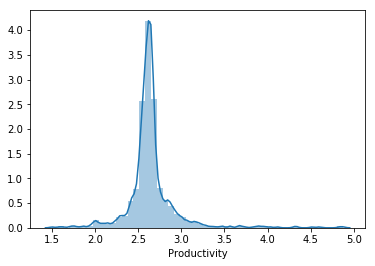

In [63]:
sns.distplot(y,bins=50)

Shows that it follows normal distribution

## Scaling

Scaling is done to avoid any bias within data

In [65]:
sc=RobustScaler()
train=sc.fit_transform(x)
dataTest=sc.transform(test)

## Machine Learning Models

### Utility function to check top models

In [66]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] ==i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### Function to calculate RMSLE

In [67]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## RandomForest

In [68]:
from sklearn.model_selection import train_test_split
tx, val_x, ty, val_y = train_test_split(train, y_label, test_size=0.1, random_state=1)

In [69]:
random_search = RandomForestRegressor(n_estimators=50)
random_search.fit(tx,ty)
preds = random_search.predict(val_x)

print ("RMSLE Value For Random Forest: ",rmsle(np.exp(val_y),np.exp(preds),False))

RMSLE Value For Random Forest:  0.0425878811421547


In [70]:
import math
from sklearn.metrics import mean_squared_log_error
math.sqrt(mean_squared_log_error(preds, val_y))


0.02435051799945365

### Here we will train again on complete data to predict on test data

In [71]:
random_search = RandomForestRegressor(n_estimators=50)
random_search.fit(train,y_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [72]:
predtest = random_search.predict(dataTest)

In [73]:
submission = pd.DataFrame({
        "Productivity": [max(0, x) for x in (np.exp(predtest)-1)]
        })
submission.to_csv('randomForest.csv', index=False)

Comparing Distribution of Productivity among train and test

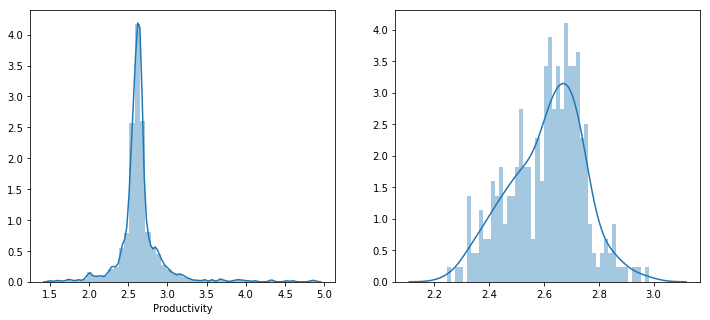

In [74]:
predsTest = random_search.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest)-1,ax=ax2,bins=50)

## GradientBoostingRegressor

In [75]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=50,alpha=0.0001)

In [76]:
gbm.fit(tx, ty)
preds = gbm.predict(val_x)
print ("RMSLE Value For GBM: ",rmsle(np.exp(val_y),np.exp(preds),False))

RMSLE Value For GBM:  0.04528553716104058


In [77]:
gbm = GradientBoostingRegressor(n_estimators=50,alpha=0.0001)
gbm.fit(train, y_label)

GradientBoostingRegressor(alpha=0.0001, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

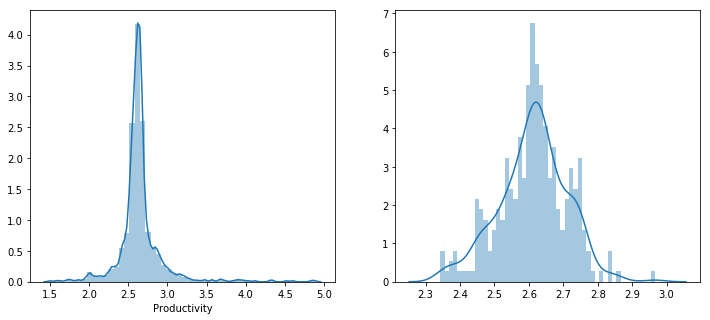

In [78]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest)-1,ax=ax2,bins=50)

### We got better accuracy for RandomForest